# Evaluation Analysis

Import libraries

In [54]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import numpy as np

import itertools
from scipy.stats import shapiro
from scipy.stats import wilcoxon

### Auxiliary Function

In [55]:
tool_name_map = {
        'semantic_kernel': 'SK',
        'semantic_kernel_chat': 'SK Chat',
        'autogen': 'AutoGen',
        'dify': 'Dify',
        'autogpt': 'AutoGPT',
        'langchain': 'LangChain'
    }

In [56]:
def load_files(main_folder, target_filename):
    # Initialize list to hold file paths
    file_paths = {}

    # Iterate through subdirectories
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)
        
        if os.path.isdir(subfolder_path):
            target_path = os.path.join(subfolder_path, target_filename)
            
            if os.path.isfile(target_path):
                file_paths[subfolder] = target_path
    print(file_paths)
    return file_paths
        

In [57]:
def get_tool_color_map(df):
    mapped_tools = df['tool'].map(tool_name_map).fillna(df['tool'])
    
    # Original order sorted alphabetically (without moving langchain)
    original_order = sorted(mapped_tools.unique(), key=lambda x: x.lower())
    
    # Add langchain as last
    if 'LangChain' in original_order:
        original_order.remove('LangChain')
    original_order.append('LangChain')
    
    original_palette = sns.color_palette('Set2', len(original_order))
    original_color_map = dict(zip(original_order, original_palette))

    # New order: put 'langchain' first, then the others in their original order (without langchain)
    new_order = ['LangChain'] + [tool for tool in original_order if tool != 'LangChain']

    return original_color_map, new_order

In [58]:
def plot_compare(df, column_name, title=None):
    df = df.copy()
    df['tool'] = df['tool'].map(tool_name_map).fillna(df['tool'])

    # Get consistent color map and tool order
    color_map, tool_order = get_tool_color_map(df)
    df['tool'] = pd.Categorical(df['tool'], categories=tool_order, ordered=True)

    # Create custom palette using tool order and color map
    palette = [color_map[tool] for tool in tool_order]

    plt.figure(figsize=(10, 5))
    sns.violinplot(
        data=df,
        x='tool',
        y=column_name,
        hue='tool',
        palette=palette,
        legend=False,
        order=tool_order
    )

    plt.xlabel("Framework", fontsize=24)
    plt.ylabel(column_name, fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    if title:
        plt.title(title, fontsize=16)

    plt.tight_layout()
    plt.show()



## Loading Data

#### Evaluation

In [59]:
# Load evaluation function
def load_evaluation_files(file_paths):
    list_df = []
    for tool, file_name in file_paths.items():
        df_original =  pd.read_csv(file_name)
        column_names = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]
        df_rouge = df_original[column_names].copy()  
        df_rouge["tool"] = tool
        list_df.append(df_rouge)
    
    return pd.concat(list_df)

In [60]:
# Configuration
main_folder = 'evaluation'
dic_file_paths_10 = load_files(main_folder, 'evaluation_TS10.csv')
dic_file_paths_50 = load_files(main_folder, 'evaluation_TS50.csv')

{'langchain': 'evaluation/langchain/evaluation_TS10.csv', 'autogpt': 'evaluation/autogpt/evaluation_TS10.csv', 'semantic_kernel': 'evaluation/semantic_kernel/evaluation_TS10.csv', 'autogen': 'evaluation/autogen/evaluation_TS10.csv', 'dify': 'evaluation/dify/evaluation_TS10.csv', 'semantic_kernel_chat': 'evaluation/semantic_kernel_chat/evaluation_TS10.csv'}
{'langchain': 'evaluation/langchain/evaluation_TS50.csv', 'autogpt': 'evaluation/autogpt/evaluation_TS50.csv', 'semantic_kernel': 'evaluation/semantic_kernel/evaluation_TS50.csv', 'autogen': 'evaluation/autogen/evaluation_TS50.csv', 'dify': 'evaluation/dify/evaluation_TS50.csv', 'semantic_kernel_chat': 'evaluation/semantic_kernel_chat/evaluation_TS50.csv'}


Load TS10

In [61]:
df_10 = load_evaluation_files(dic_file_paths_10)
df_10

,ROUGE-1,ROUGE-2,ROUGE-L,tool
0,1.000000,1.000000,1.000000,langchain
1,1.000000,1.000000,1.000000,langchain
2,1.000000,0.911765,0.971429,langchain
3,0.363636,0.300000,0.363636,langchain
4,0.421053,0.235294,0.421053,langchain
...,...,...,...,...
860,0.413793,0.296296,0.413793,semantic_kernel_chat
861,0.769231,0.545455,0.769231,semantic_kernel_chat
862,0.400000,0.000000,0.200000,semantic_kernel_chat
863,0.750000,0.454545,0.750000,semantic_kernel_chat


Load TS50

In [62]:
df_50 = load_evaluation_files(dic_file_paths_50)
df_50

,ROUGE-1,ROUGE-2,ROUGE-L,tool
0,1.000000,1.000000,1.000000,langchain
1,0.842105,0.823529,0.842105,langchain
2,1.000000,0.911765,0.971429,langchain
3,0.363636,0.300000,0.363636,langchain
4,0.421053,0.235294,0.421053,langchain
...,...,...,...,...
860,0.387097,0.206897,0.322581,semantic_kernel_chat
861,0.769231,0.545455,0.769231,semantic_kernel_chat
862,0.500000,0.200000,0.333333,semantic_kernel_chat
863,0.888889,0.800000,0.888889,semantic_kernel_chat


#### Token Usage

In [63]:

# Load usage files and preprocess them -
def load_usage(dic_file_paths):
    list_df = []
    for tool, file_name in dic_file_paths.items():
        df_original =  pd.read_csv(file_name, sep=";")
        df_original.dropna(subset=["input_tokens"], inplace=True)
        summary = {
            "total_time_minutes": (df_original["end_time"].max() - df_original["start_time"].min())/60, # Transform to minutes because is the granularity provided by OpenAI
            "total_input_tokens": df_original["input_tokens"].sum(),
            "total_output_tokens": df_original["output_tokens"].sum(),
            "total_tokens": df_original["input_tokens"].sum() + df_original["output_tokens"].sum(),
            "total_requests": df_original["num_model_requests"].sum(),
            "tool": tool
        }
        summary_df = pd.DataFrame([summary])
        list_df.append(summary_df)
    
    return pd.concat(list_df)

def load_usage_by_models(dic_file_paths):
    list_df = []
    for tool, file_name in dic_file_paths.items():
        df_original =  pd.read_csv(file_name, sep=";")
        df_original.dropna(subset=["input_tokens"], inplace=True)
        grouped = df_original.groupby("model")

        for model_name, group in grouped:
            summary = {
                "tool": tool,
                "model": model_name,
                "total_input_tokens": group["input_tokens"].sum(),
                "total_output_tokens": group["output_tokens"].sum(),
                "total_tokens": group["input_tokens"].sum() + group["output_tokens"].sum(),
                "total_requests": group["num_model_requests"].sum(),
            }
            summary_df = pd.DataFrame([summary])
            list_df.append(summary_df)
    
    return pd.concat(list_df)

Load TS10 and TS50

In [64]:
# Configuration
main_folder = 'token_usage'

dic_usage_train_10 = load_files(main_folder, 'train_TS10.csv')
dic_usage_train_50 = load_files(main_folder, 'train_TS50.csv')

dic_usage_eval_10 = load_files(main_folder, 'evaluation_TS10.csv')
dic_usage_eval_50 = load_files(main_folder, 'evaluation_TS50.csv')

{'autogpt': 'token_usage/autogpt/train_TS10.csv', 'semantic_kernel': 'token_usage/semantic_kernel/train_TS10.csv', 'autogen': 'token_usage/autogen/train_TS10.csv', 'dify': 'token_usage/dify/train_TS10.csv', 'semantic_kernel_chat': 'token_usage/semantic_kernel_chat/train_TS10.csv'}
{'autogpt': 'token_usage/autogpt/train_TS50.csv', 'semantic_kernel': 'token_usage/semantic_kernel/train_TS50.csv', 'autogen': 'token_usage/autogen/train_TS50.csv', 'dify': 'token_usage/dify/train_TS50.csv', 'semantic_kernel_chat': 'token_usage/semantic_kernel_chat/train_TS50.csv'}
{'autogpt': 'token_usage/autogpt/evaluation_TS10.csv', 'semantic_kernel': 'token_usage/semantic_kernel/evaluation_TS10.csv', 'autogen': 'token_usage/autogen/evaluation_TS10.csv', 'dify': 'token_usage/dify/evaluation_TS10.csv', 'semantic_kernel_chat': 'token_usage/semantic_kernel_chat/evaluation_TS10.csv'}
{'autogpt': 'token_usage/autogpt/evaluation_TS50.csv', 'semantic_kernel': 'token_usage/semantic_kernel/evaluation_TS50.csv', 'aut

## Comparing Frameworks

### ROUGE scores - TS10

In [65]:
grouped = df_10.groupby("tool")[["ROUGE-1", "ROUGE-2", "ROUGE-L"]]
mean_values = grouped.mean().round(3)
std_values = grouped.std().round(3)

# Display results
print("Mean values per tool:")
print(mean_values)

print("\nStandard deviation per tool:")
print(std_values)

Mean values per tool:
                      ROUGE-1  ROUGE-2  ROUGE-L
tool                                           
autogen                 0.488    0.294    0.441
autogpt                 0.473    0.275    0.428
dify                    0.515    0.352    0.479
langchain               0.536    0.377    0.503
semantic_kernel         0.505    0.344    0.472
semantic_kernel_chat    0.472    0.278    0.427

Standard deviation per tool:
                      ROUGE-1  ROUGE-2  ROUGE-L
tool                                           
autogen                 0.257    0.292    0.264
autogpt                 0.247    0.274    0.253
dify                    0.291    0.339    0.301
langchain               0.292    0.350    0.304
semantic_kernel         0.293    0.336    0.300
semantic_kernel_chat    0.251    0.276    0.256


### ROUGE scores - TS50

In [66]:
grouped = df_50.groupby("tool")[["ROUGE-1", "ROUGE-2", "ROUGE-L"]]
mean_values = grouped.mean().round(3)
std_values = grouped.std().round(3)

# Display results
print("Mean values per tool:")
print(mean_values)

print("\nStandard deviation per tool:")
print(std_values)

Mean values per tool:
                      ROUGE-1  ROUGE-2  ROUGE-L
tool                                           
autogen                 0.486    0.293    0.441
autogpt                 0.462    0.254    0.408
dify                    0.503    0.320    0.459
langchain               0.523    0.364    0.486
semantic_kernel         0.487    0.300    0.444
semantic_kernel_chat    0.483    0.285    0.435

Standard deviation per tool:
                      ROUGE-1  ROUGE-2  ROUGE-L
tool                                           
autogen                 0.256    0.291    0.263
autogpt                 0.239    0.261    0.243
dify                    0.270    0.314    0.279
langchain               0.285    0.341    0.297
semantic_kernel         0.264    0.301    0.272
semantic_kernel_chat    0.253    0.279    0.257


### Normality Test

In [67]:
# List of frameworks and metrics
frameworks = ['autogen', 'autogpt', 'dify', 'semantic_kernel', 'semantic_kernel_chat', 'langchain']
metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

def normality_test(df: pd.DataFrame, frameworks: list, metrics: list, label_column: str = "tool"):
    print("🔍 Normality (Shapiro–Wilk test):")
    for metric in metrics:
        for framework in frameworks:
            data = df[df[label_column] == framework][metric]
            stat, p = shapiro(data)
            print(f"{framework} - {metric}: p = {p:.4f} {'(Not Normal)' if p < 0.05 else '(Normal)'}")

In [68]:
normality_test(df_10, frameworks, metrics)

🔍 Normality (Shapiro–Wilk test):
autogen - ROUGE-1: p = 0.0000 (Not Normal)
autogpt - ROUGE-1: p = 0.0000 (Not Normal)
dify - ROUGE-1: p = 0.0000 (Not Normal)
semantic_kernel - ROUGE-1: p = 0.0000 (Not Normal)
semantic_kernel_chat - ROUGE-1: p = 0.0000 (Not Normal)
langchain - ROUGE-1: p = 0.0000 (Not Normal)
autogen - ROUGE-2: p = 0.0000 (Not Normal)
autogpt - ROUGE-2: p = 0.0000 (Not Normal)
dify - ROUGE-2: p = 0.0000 (Not Normal)
semantic_kernel - ROUGE-2: p = 0.0000 (Not Normal)
semantic_kernel_chat - ROUGE-2: p = 0.0000 (Not Normal)
langchain - ROUGE-2: p = 0.0000 (Not Normal)
autogen - ROUGE-L: p = 0.0000 (Not Normal)
autogpt - ROUGE-L: p = 0.0000 (Not Normal)
dify - ROUGE-L: p = 0.0000 (Not Normal)
semantic_kernel - ROUGE-L: p = 0.0000 (Not Normal)
semantic_kernel_chat - ROUGE-L: p = 0.0000 (Not Normal)
langchain - ROUGE-L: p = 0.0000 (Not Normal)


In [69]:
normality_test(df_50, frameworks, metrics)

🔍 Normality (Shapiro–Wilk test):
autogen - ROUGE-1: p = 0.0000 (Not Normal)
autogpt - ROUGE-1: p = 0.0000 (Not Normal)
dify - ROUGE-1: p = 0.0000 (Not Normal)
semantic_kernel - ROUGE-1: p = 0.0000 (Not Normal)
semantic_kernel_chat - ROUGE-1: p = 0.0000 (Not Normal)
langchain - ROUGE-1: p = 0.0000 (Not Normal)
autogen - ROUGE-2: p = 0.0000 (Not Normal)
autogpt - ROUGE-2: p = 0.0000 (Not Normal)
dify - ROUGE-2: p = 0.0000 (Not Normal)
semantic_kernel - ROUGE-2: p = 0.0000 (Not Normal)
semantic_kernel_chat - ROUGE-2: p = 0.0000 (Not Normal)
langchain - ROUGE-2: p = 0.0000 (Not Normal)
autogen - ROUGE-L: p = 0.0000 (Not Normal)
autogpt - ROUGE-L: p = 0.0000 (Not Normal)
dify - ROUGE-L: p = 0.0000 (Not Normal)
semantic_kernel - ROUGE-L: p = 0.0000 (Not Normal)
semantic_kernel_chat - ROUGE-L: p = 0.0000 (Not Normal)
langchain - ROUGE-L: p = 0.0000 (Not Normal)


### Wilcoxon Test

In [70]:
def run_pairwise_wilcoxon(df, frameworks, metrics, alpha=0.05):

    pairs = list(itertools.combinations(sorted(frameworks), 2))
    corrected_alpha = alpha  # or alpha / len(pairs) for Bonferroni

    results = []

    for metric in metrics:
        for fw1, fw2 in pairs:
            # Ensure alphabetical order within pair
            # fw1, fw2 = sorted([fw1, fw2])
            scores1 = df[df['tool'] == fw1][metric].reset_index(drop=True)
            scores2 = df[df['tool'] == fw2][metric].reset_index(drop=True)

            if len(scores1) != len(scores2):
                print(f"Warning: Mismatch in sample size for {fw1} vs {fw2} on {metric}. Skipping.")
                continue

            stat, p = wilcoxon(scores1, scores2)
            p_rounded = round(p, 3)
            significant = p < corrected_alpha

            results.append({
                "Metric": metric,
                "Framework 1": fw1,
                "Framework 2": fw2,
                "p-value": p_rounded,
                "Significant": "✓" if significant else "✗"
            })

    result_df = pd.DataFrame(results)

    for metric in metrics:
        print(f"\n=== {metric} ===")
        print(result_df[result_df["Metric"] == metric]
              .drop(columns="Metric")
              .sort_values(by=["Framework 1", "Framework 2"])
              .to_string(index=False))


Train 10

In [71]:
run_pairwise_wilcoxon(df_10, frameworks, metrics)


=== ROUGE-1 ===
    Framework 1          Framework 2  p-value Significant
        autogen              autogpt    0.000           ✓
        autogen                 dify    0.000           ✓
        autogen      semantic_kernel    0.014           ✓
        autogen semantic_kernel_chat    0.000           ✓
        autogpt                 dify    0.000           ✓
        autogpt      semantic_kernel    0.000           ✓
        autogpt semantic_kernel_chat    0.995           ✗
           dify      semantic_kernel    0.053           ✗
           dify semantic_kernel_chat    0.000           ✓
semantic_kernel semantic_kernel_chat    0.000           ✓

=== ROUGE-2 ===
    Framework 1          Framework 2  p-value Significant
        autogen              autogpt    0.000           ✓
        autogen                 dify    0.000           ✓
        autogen      semantic_kernel    0.000           ✓
        autogen semantic_kernel_chat    0.106           ✗
        autogpt                 dify  

Train 50

In [72]:
run_pairwise_wilcoxon(df_50, frameworks, metrics)


=== ROUGE-1 ===
    Framework 1          Framework 2  p-value Significant
        autogen              autogpt    0.000           ✓
        autogen                 dify    0.001           ✓
        autogen      semantic_kernel    0.451           ✗
        autogen semantic_kernel_chat    0.095           ✗
        autogpt                 dify    0.000           ✓
        autogpt      semantic_kernel    0.000           ✓
        autogpt semantic_kernel_chat    0.000           ✓
           dify      semantic_kernel    0.001           ✓
           dify semantic_kernel_chat    0.000           ✓
semantic_kernel semantic_kernel_chat    0.678           ✗

=== ROUGE-2 ===
    Framework 1          Framework 2  p-value Significant
        autogen              autogpt    0.000           ✓
        autogen                 dify    0.000           ✓
        autogen      semantic_kernel    0.061           ✗
        autogen semantic_kernel_chat    0.254           ✗
        autogpt                 dify  

#### ROUGE-L

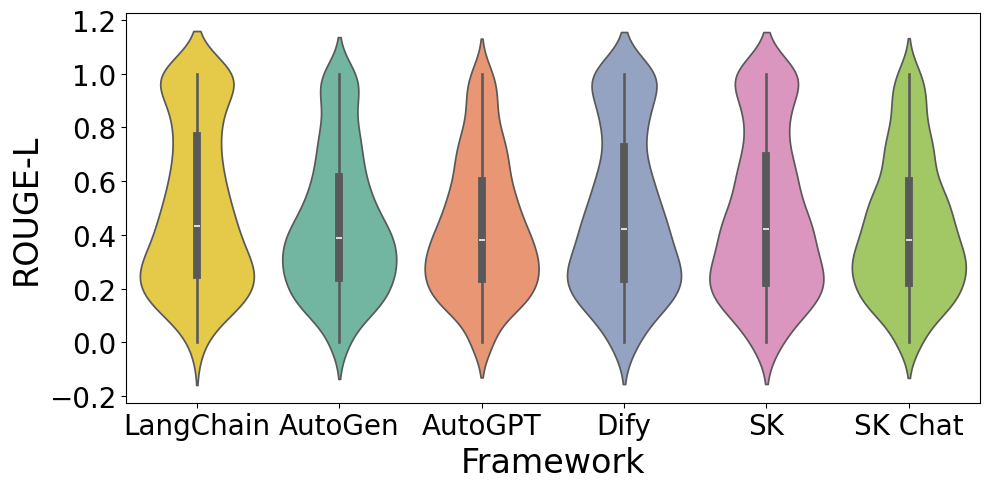

In [73]:
plot_compare(df_10, "ROUGE-L")

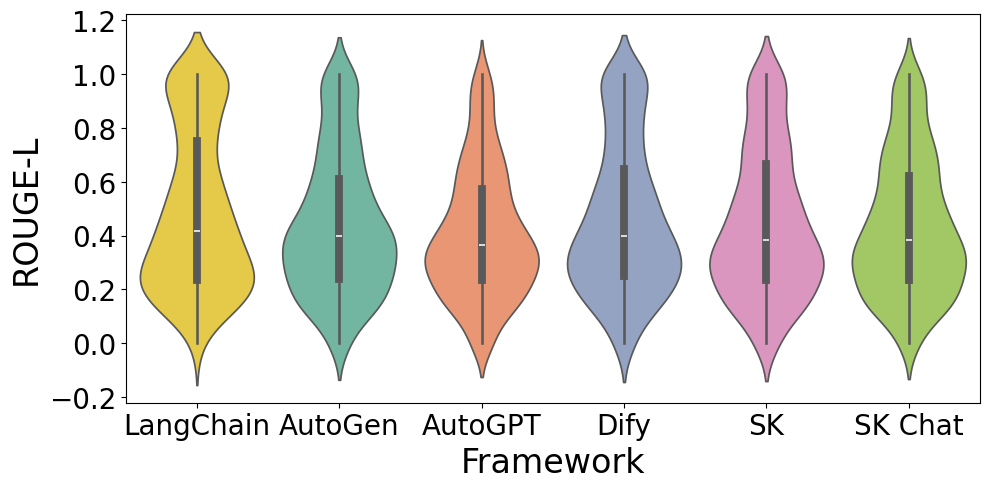

In [74]:
plot_compare(df_50, "ROUGE-L")

#### ROUGE-1

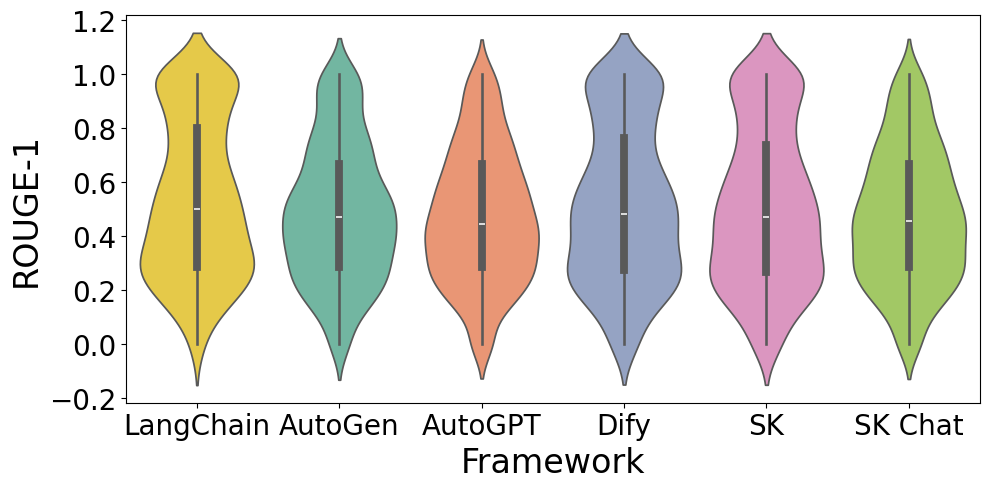

In [75]:
plot_compare(df_10, "ROUGE-1")

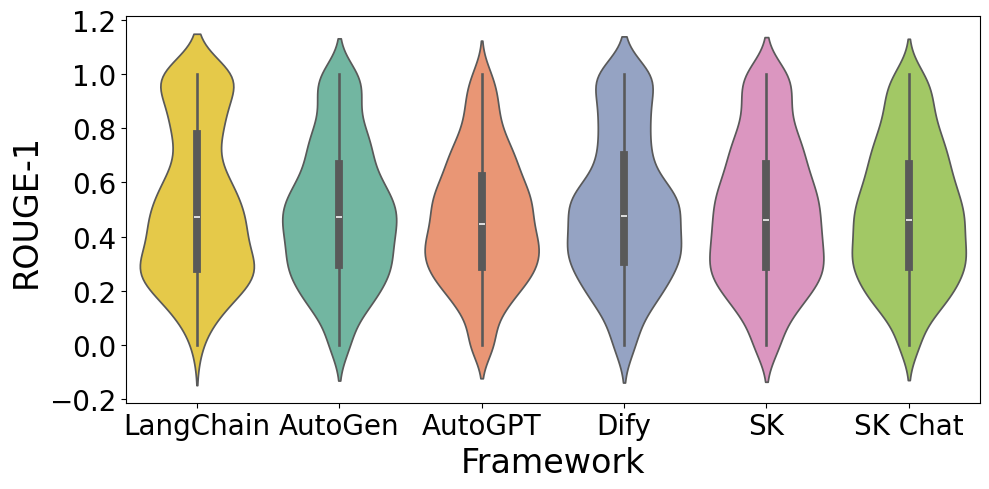

In [76]:
plot_compare(df_50, "ROUGE-1")

#### ROUGE-2

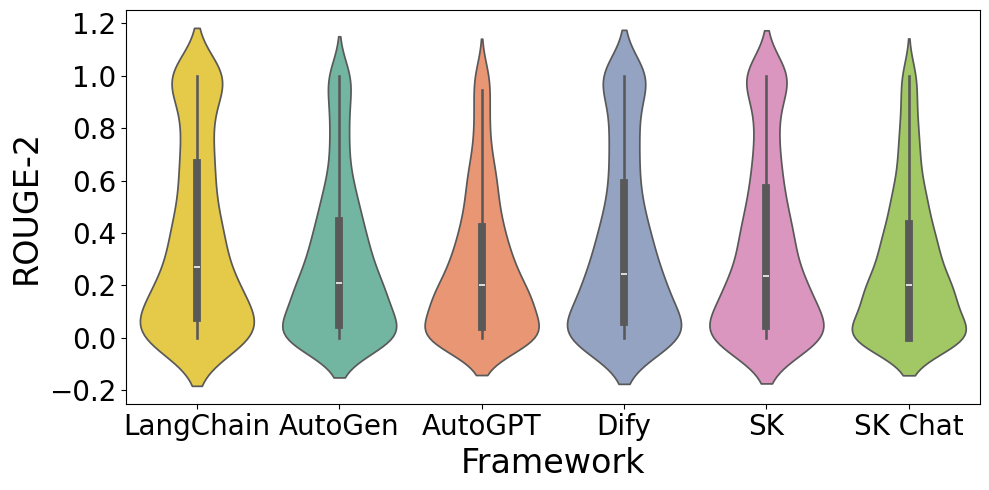

In [77]:
plot_compare(df_10, "ROUGE-2")

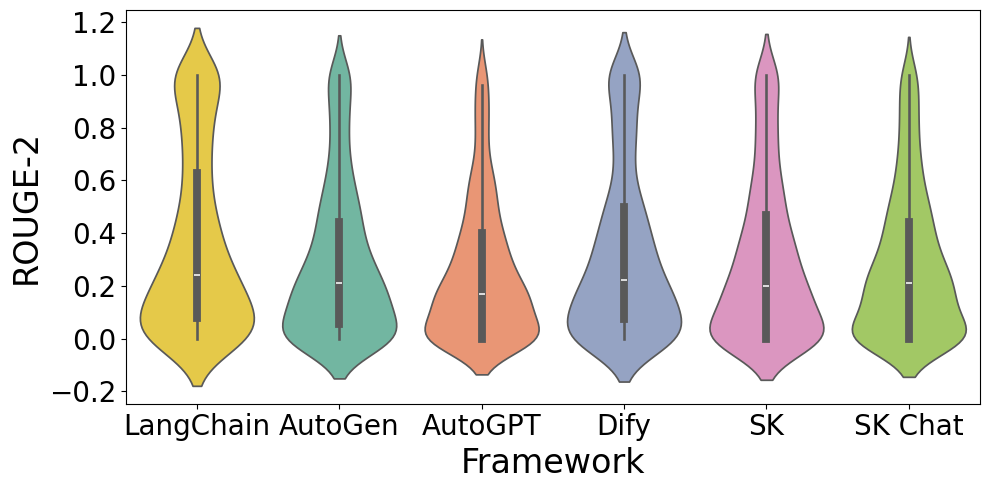

In [78]:
plot_compare(df_50, "ROUGE-2")

### Model Usage Consumption

In [79]:
metric_labels = {
    'total_time_minutes': 'Total Time (minutes)',
    'total_input_tokens': 'Total Input Tokens',
    'total_output_tokens': 'Total Output Tokens',
    'total_requests': 'Total Requests'
}

#### General Analysis

Train

In [80]:
# TS10
df_usage_train_10 = load_usage(dic_usage_train_10)
df_usage_train_10

,total_time_minutes,total_input_tokens,total_output_tokens,total_tokens,total_requests,tool
0,11.0,77956.0,11779.0,89735.0,149.0,autogpt
0,5.0,89360.0,12782.0,102142.0,165.0,semantic_kernel
0,5.0,80316.0,10962.0,91278.0,153.0,autogen
0,5.0,94293.0,11872.0,106165.0,177.0,dify
0,36.0,6436783.0,58575.0,6495358.0,1121.0,semantic_kernel_chat


In [81]:
# TS50
df_usage_train_50 = load_usage(dic_usage_train_50)
df_usage_train_50

,total_time_minutes,total_input_tokens,total_output_tokens,total_tokens,total_requests,tool
0,48.0,358155.0,46362.0,404517.0,715.0,autogpt
0,16.0,321405.0,41303.0,362708.0,661.0,semantic_kernel
0,17.0,316829.0,38745.0,355574.0,651.0,autogen
0,19.0,326516.0,36725.0,363241.0,627.0,dify
0,154.0,28394249.0,244117.0,28638366.0,4813.0,semantic_kernel_chat


Evaluation

In [82]:
# TS10
df_usage_eval_10 = load_usage(dic_usage_eval_10)
df_usage_eval_10

,total_time_minutes,total_input_tokens,total_output_tokens,total_tokens,total_requests,tool
0,180.0,1717358.0,101073.0,1818431.0,1730.0,autogpt
0,55.0,1791934.0,99211.0,1891145.0,1730.0,semantic_kernel
0,37.0,1809945.0,96555.0,1906500.0,1730.0,autogen
0,52.0,1780627.0,98458.0,1879085.0,1730.0,dify
0,47.0,1811930.0,93954.0,1905884.0,1730.0,semantic_kernel_chat


In [83]:
df_usage_eval_50 = load_usage(dic_usage_eval_50)
df_usage_eval_50

,total_time_minutes,total_input_tokens,total_output_tokens,total_tokens,total_requests,tool
0,180.0,1740406.0,99347.0,1839753.0,1730.0,autogpt
0,49.0,1815191.0,97145.0,1912336.0,1730.0,semantic_kernel
0,53.0,1808654.0,95311.0,1903965.0,1730.0,autogen
0,52.0,1795206.0,97863.0,1893069.0,1730.0,dify
0,47.0,1812327.0,95592.0,1907919.0,1730.0,semantic_kernel_chat


### Plots

In [84]:
def plot_individual_metrics(df):
    df = df.copy()
    df['tool'] = df['tool'].map(tool_name_map).fillna(df['tool'])

    # Get consistent color map and tool order
    color_map, tool_order = get_tool_color_map(df)
    df['tool'] = pd.Categorical(df['tool'], categories=tool_order, ordered=True)

    # Metrics to plot
    metrics = ['total_time_minutes', 'total_input_tokens', 'total_output_tokens', 'total_tokens', 'total_requests']
    metric_labels = {
        'total_time_minutes': 'Total Time (minutes)',
        'total_input_tokens': 'Total Input Tokens',
        'total_output_tokens': 'Total Output Tokens',
        'total_tokens': 'Total Tokens',
        'total_requests': 'Total Requests'
    }

    # Create palette using tool order
    palette = [color_map[tool] for tool in tool_order]

    for metric in metrics:
        plt.figure(figsize=(9, 5))
        sns.barplot(
            data=df,
            x='tool',
            y=metric,
            palette=palette,
            hue='tool',
            legend=False,
            order=tool_order
        )
        plt.title(f"{metric_labels[metric]} by Framework", fontsize=14)
        plt.xlabel("Framework", fontsize=12)
        plt.ylabel(metric_labels[metric], fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', linewidth=0.5, zorder=0)  # Add horizontal lines
        plt.tight_layout()
        plt.show()



In [85]:

def plot_input_output_tokens_log(df):
    df = df.copy()
    df['tool'] = df['tool'].map(tool_name_map).fillna(df['tool'])

    # Get consistent color map and tool order
    color_map, tool_order = get_tool_color_map(df)
    # Remove LangChain
    langchain_name = "LangChain"
    color_map.pop(langchain_name)
    tool_order.remove(langchain_name)
    # Get tools
    df['tool'] = pd.Categorical(df['tool'], categories=tool_order, ordered=True)


    # Melt the DataFrame for plotting
    df_melted = df.melt(
        id_vars='tool',
        value_vars=['total_input_tokens', 'total_output_tokens'],
        var_name='Token Type',
        value_name='Token Count'
    )

    df_melted['Token Type'] = df_melted['Token Type'].map({
        'total_input_tokens': 'Input Tokens',
        'total_output_tokens': 'Output Tokens'
    })

    df_melted['Token Count'] = df_melted['Token Count'].replace(0, np.nan)
    
    # Compute shared Y-axis limits (log scale)
    min_y = pow(10,3)
    max_y = pow(10,8)

    plt.figure(figsize=(10, 7))
    bar_width = 0.35
    x = np.arange(len(tool_order))

    for i, tool in enumerate(tool_order):
        input_val = df_melted[
            (df_melted['tool'] == tool) & (df_melted['Token Type'] == 'Input Tokens')
        ]['Token Count'].values

        output_val = df_melted[
            (df_melted['tool'] == tool) & (df_melted['Token Type'] == 'Output Tokens')
        ]['Token Count'].values

        if input_val.size > 0:
            plt.bar(
                x[i] - bar_width / 2, input_val[0],
                width=bar_width,
                color=color_map[tool],
                edgecolor='black',
                zorder=3
            )

        if output_val.size > 0:
            plt.bar(
                x[i] + bar_width / 2, output_val[0],
                width=bar_width,
                color=color_map[tool],
                hatch='...',
                edgecolor='black',
                zorder=3
            )

    plt.yscale('log')
    plt.ylim(min_y, max_y)
    plt.xticks(ticks=x, labels=tool_order, rotation=45, fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Framework', fontsize=24)
    plt.ylabel('Token Count (log scale)', fontsize=24)
    plt.title('Input and Output Tokens by Framework', fontsize=26)
    plt.grid(axis='y', linestyle='--', linewidth=0.5, zorder=0)

    # Custom legend with default (fully opaque) patches
    solid_patch = mpatches.Patch(facecolor='gray', label='Input Tokens')
    hatched_patch = mpatches.Patch(facecolor='gray', hatch='...', edgecolor='black', label='Output Tokens')
    plt.legend(handles=[solid_patch, hatched_patch], title='Token Type', loc='upper left', 
               fontsize=18,title_fontsize=20)

    plt.tight_layout()
    plt.show()


Plot TS10 - Optimization

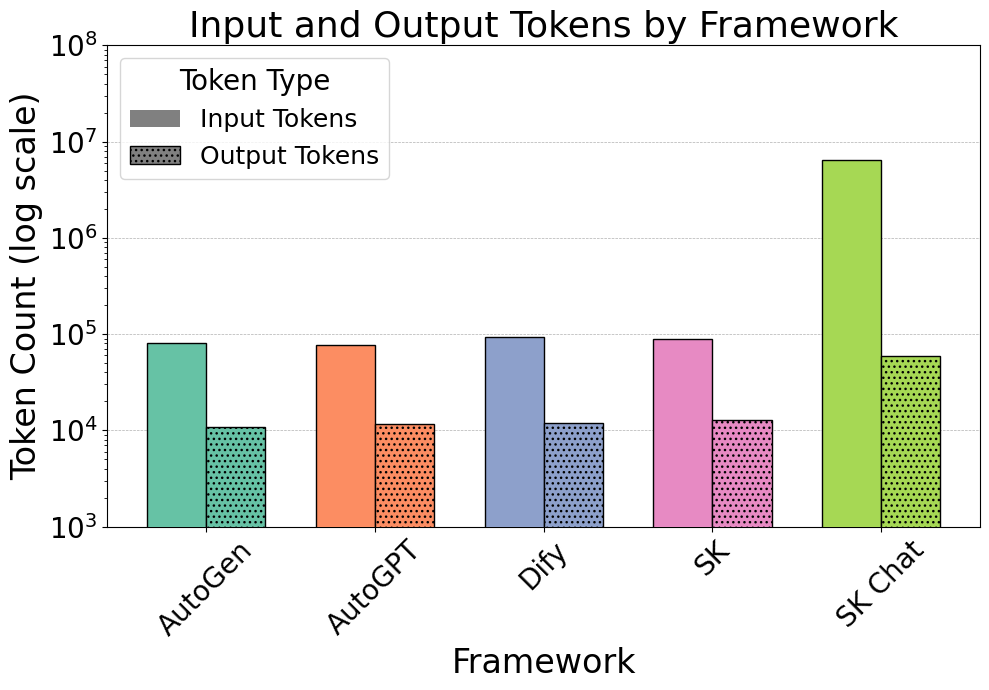

In [86]:
plot_input_output_tokens_log(df_usage_train_10)

In [87]:
# Old plots
# plot_individual_metrics(df_usage_train_10)

Plot TS50 - Optimization

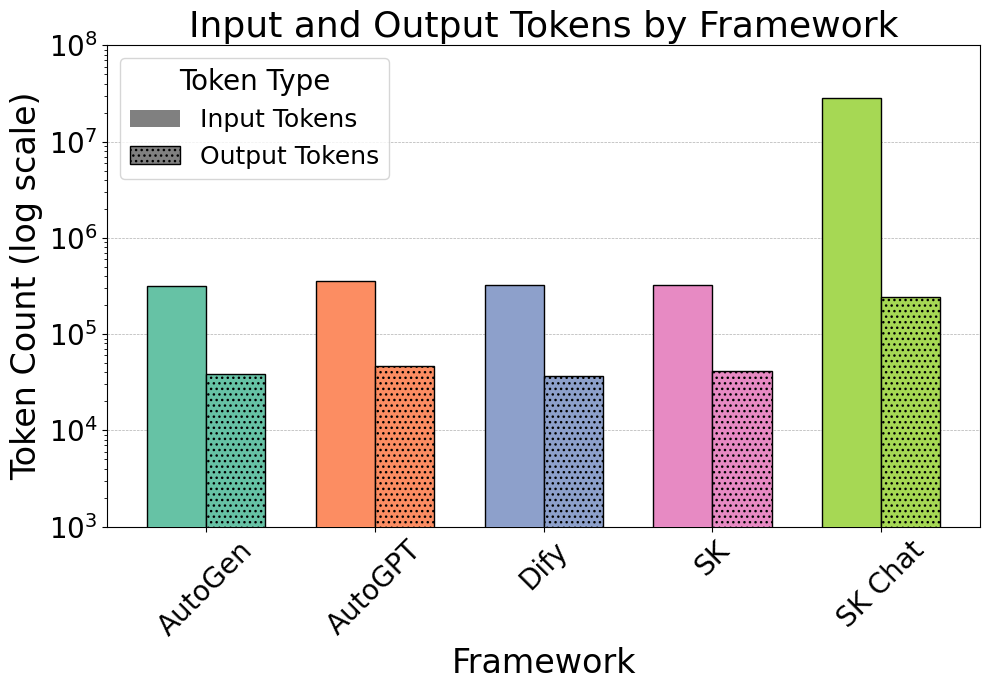

In [88]:
plot_input_output_tokens_log(df_usage_train_50)

In [89]:
# Old plots
# plot_individual_metrics(df_usage_train_50)

Evaluation

TS10

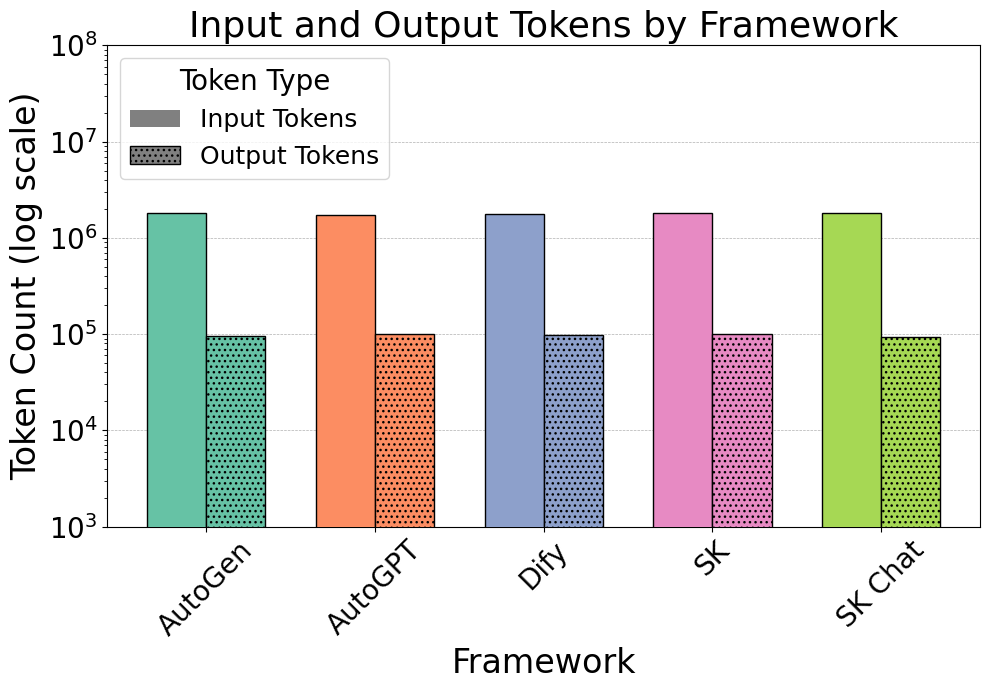

In [90]:
plot_input_output_tokens_log(df_usage_eval_10)

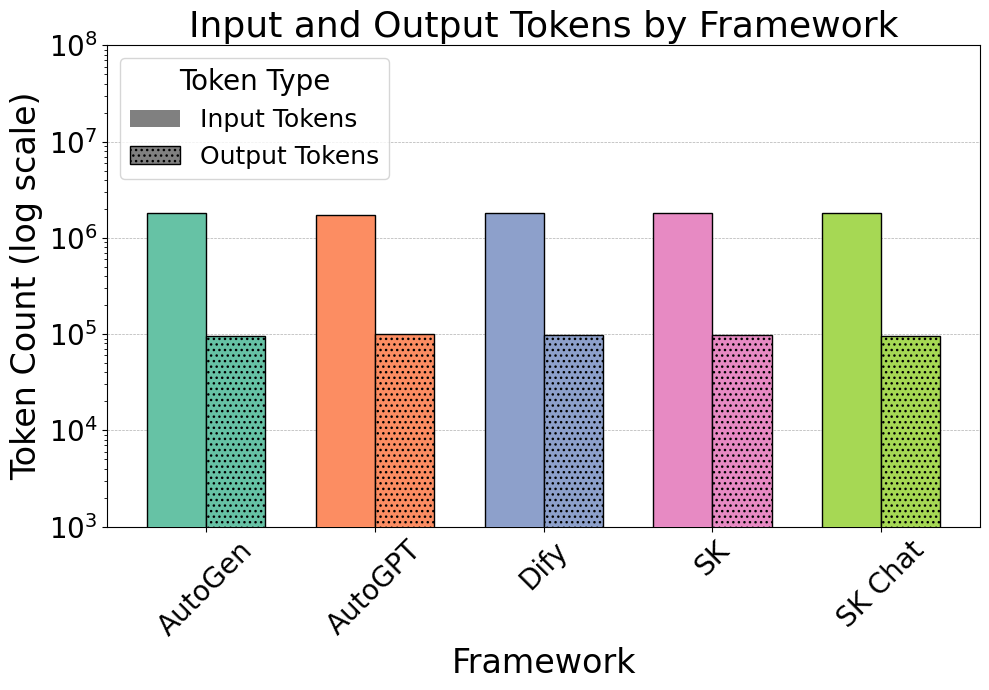

In [91]:
plot_input_output_tokens_log(df_usage_eval_50)

Other metrics - Number of Requests and Total Time

In [92]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

def plot_metric_comparison(df1, df2, metric, label1='Optimization', label2='Evaluation'):
    df1 = df1.copy()
    df2 = df2.copy()

    # Standardize tool names
    df1['tool'] = df1['tool'].map(tool_name_map).fillna(df1['tool'])
    df2['tool'] = df2['tool'].map(tool_name_map).fillna(df2['tool'])

    # Add source labels
    df1['Source'] = label1
    df2['Source'] = label2

    # Combine data
    df_combined = pd.concat([df1, df2], ignore_index=True)

    # Get consistent tool order and color map
    color_map, tool_order = get_tool_color_map(df_combined)
    # Remove LangChain
    langchain_name = "LangChain"
    color_map.pop(langchain_name)
    tool_order.remove(langchain_name)
    # Get tools
    df_combined['tool'] = pd.Categorical(df_combined['tool'], categories=tool_order, ordered=True)

    # Set up the figure
    plt.figure(figsize=(10, 7))
    bar_width = 0.35
    x = np.arange(len(tool_order))

    for i, tool in enumerate(tool_order):
        val1 = df1[df1['tool'] == tool][metric].values
        val2 = df2[df2['tool'] == tool][metric].values

        # Input bars (Run 1 - solid)
        if val1.size > 0:
            plt.bar(x[i] - bar_width/2, val1[0], width=bar_width,
                    color=color_map[tool], zorder=3,edgecolor='black', label=label1 if i == 0 else None)

        # Output bars (Run 2 - hatched)
        if val2.size > 0:
            plt.bar(x[i] + bar_width/2, val2[0], width=bar_width,
                    color=color_map[tool], hatch='///',edgecolor='black',
                    zorder=3, label=label2 if i == 0 else None)

    # Axis and labels
    metric_labels = {
        'total_time_minutes': 'Total Time (minutes)',
        'total_input_tokens': 'Total Input Tokens',
        'total_output_tokens': 'Total Output Tokens',
        'total_tokens': 'Total Tokens',
        'total_requests': 'Total Requests'
    }

    plt.xticks(ticks=x, labels=tool_order, rotation=45, fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Framework", fontsize=24)
    plt.ylabel(metric_labels.get(metric, metric), fontsize=24)
    plt.title(f"{metric_labels.get(metric, metric)} Comparison by Framework", fontsize=26)
    plt.grid(axis='y', linestyle='--', linewidth=0.5, zorder=0)

    # Custom legend (tool color + run distinction)
    solid_patch = mpatches.Patch(facecolor='gray', label=label1)
    hatched_patch = mpatches.Patch(facecolor='gray', hatch='///', edgecolor='black', label=label2)
    plt.legend(handles=[solid_patch, hatched_patch], title='Pipeline', fontsize=18,title_fontsize=20)

    plt.tight_layout()
    plt.show()


Total Time - Optimization

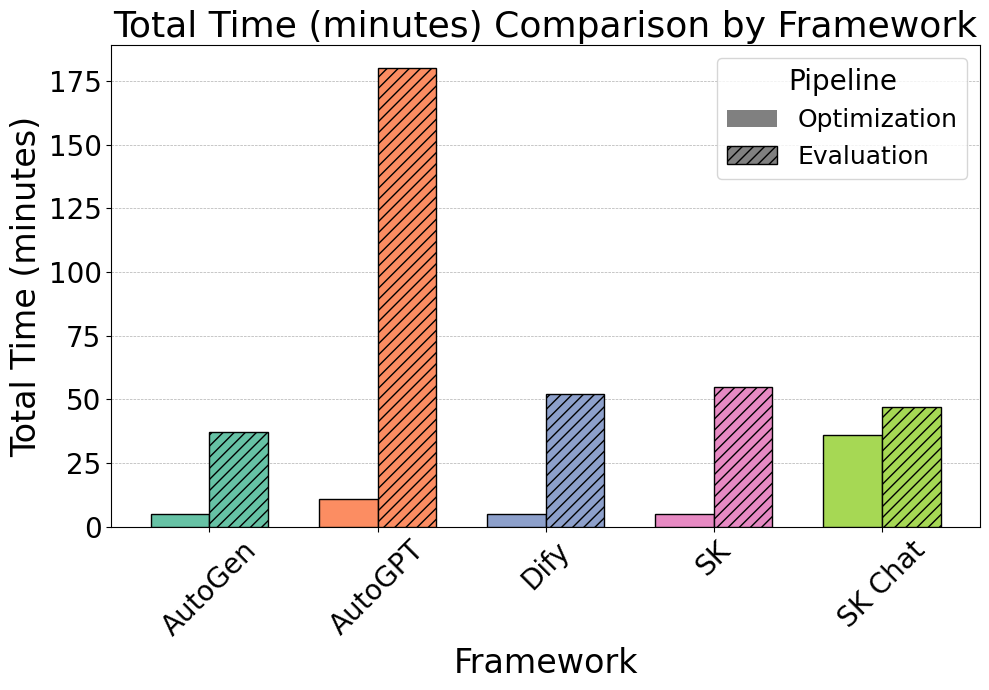

In [93]:
plot_metric_comparison(df_usage_train_10, df_usage_eval_10, "total_time_minutes", label1='Optimization', label2='Evaluation')

Total Time - Evaluation

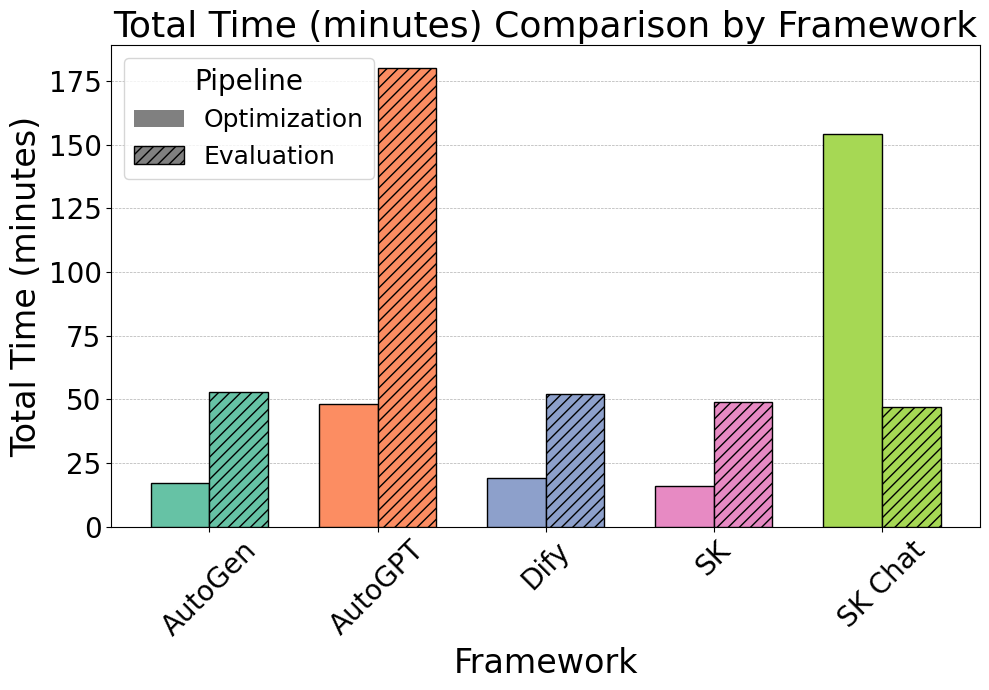

In [94]:
plot_metric_comparison(df_usage_train_50, df_usage_eval_50, "total_time_minutes", label1='Optimization', label2='Evaluation')

Requests - Optimization

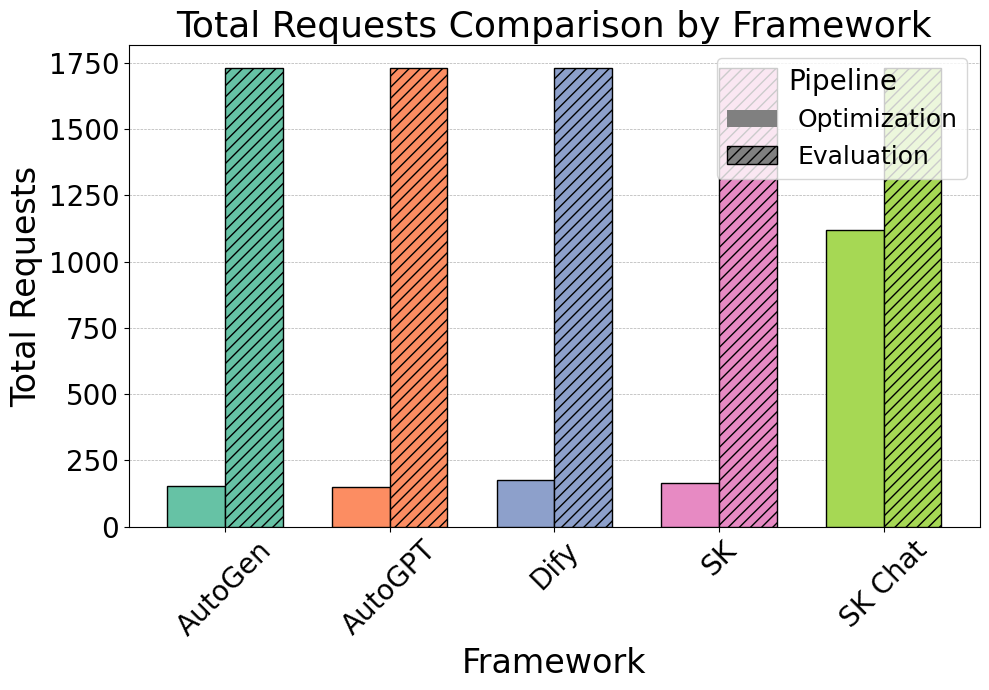

In [95]:
plot_metric_comparison(df_usage_train_10, df_usage_eval_10, "total_requests", label1='Optimization', label2='Evaluation')

Requests

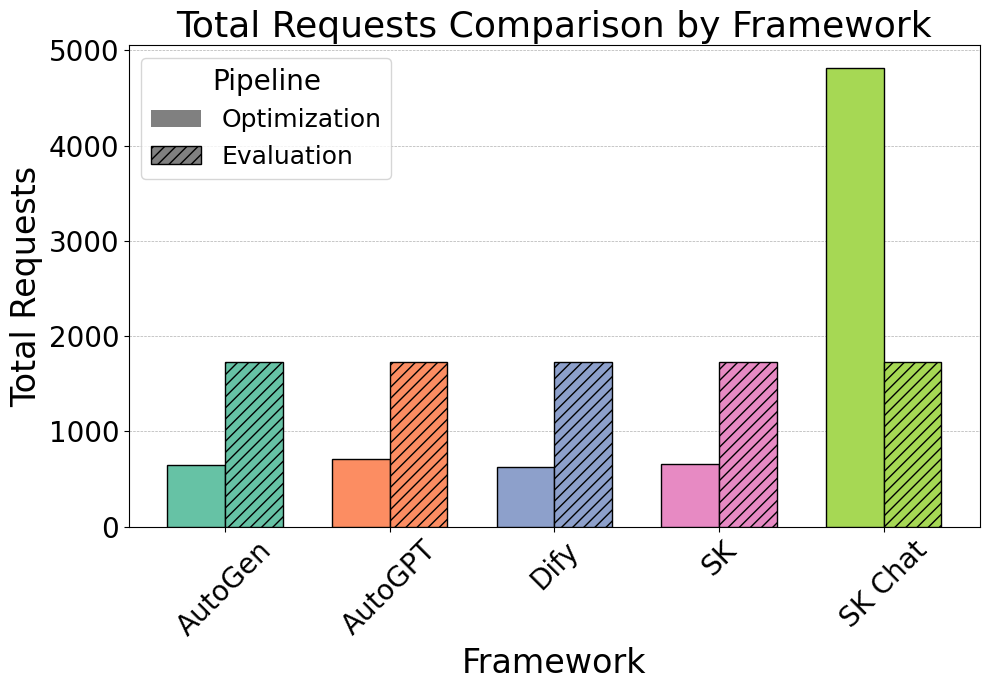

In [96]:
plot_metric_comparison(df_usage_train_50, df_usage_eval_50, "total_requests", label1='Optimization', label2='Evaluation')

### Evaluate Model Usage

In [97]:
# TS10
df_model_usage_10 = load_usage_by_models(dic_usage_train_10)
df_model_usage_10


,tool,model,total_input_tokens,total_output_tokens,total_tokens,total_requests
0,autogpt,gpt-4o-2024-08-06,48807.0,9566.0,58373.0,67.0
0,autogpt,gpt-4o-mini-2024-07-18,29149.0,2213.0,31362.0,82.0
0,semantic_kernel,gpt-4o-2024-08-06,55689.0,9621.0,65310.0,75.0
0,semantic_kernel,gpt-4o-mini-2024-07-18,33671.0,3161.0,36832.0,90.0
0,autogen,gpt-4o-2024-08-06,48257.0,8585.0,56842.0,67.0
0,autogen,gpt-4o-mini-2024-07-18,32059.0,2377.0,34436.0,86.0
0,dify,gpt-4o-2024-08-06,60653.0,9485.0,70138.0,79.0
0,dify,gpt-4o-mini-2024-07-18,33640.0,2387.0,36027.0,98.0
0,semantic_kernel_chat,gpt-4o-2024-08-06,715363.0,4148.0,719511.0,329.0
0,semantic_kernel_chat,gpt-4o-mini-2024-07-18,5721420.0,54427.0,5775847.0,792.0


In [98]:
# TS50
df_model_usage_50 = load_usage_by_models(dic_usage_train_50)
df_model_usage_50

,tool,model,total_input_tokens,total_output_tokens,total_tokens,total_requests
0,autogpt,gpt-4o-2024-08-06,213441.0,37314.0,250755.0,315.0
0,autogpt,gpt-4o-mini-2024-07-18,144714.0,9048.0,153762.0,400.0
0,semantic_kernel,gpt-4o-2024-08-06,183459.0,33255.0,216714.0,287.0
0,semantic_kernel,gpt-4o-mini-2024-07-18,137946.0,8048.0,145994.0,374.0
0,autogen,gpt-4o-2024-08-06,177171.0,30523.0,207694.0,276.0
0,autogen,gpt-4o-mini-2024-07-18,139658.0,8222.0,147880.0,375.0
0,dify,gpt-4o-2024-08-06,189871.0,28334.0,218205.0,264.0
0,dify,gpt-4o-mini-2024-07-18,136645.0,8391.0,145036.0,363.0
0,semantic_kernel_chat,gpt-4o-2024-08-06,3075262.0,19070.0,3094332.0,1375.0
0,semantic_kernel_chat,gpt-4o-mini-2024-07-18,25318987.0,225047.0,25544034.0,3438.0


In [99]:
def plot_radar_for_tool(df, tool_name):
    tool_label = tool_name_map.get(tool_name, tool_name)

    # Filter data for the selected tool
    df_tool = df[df['tool'] == tool_name]

    # Metrics to compare
    metrics = ['total_input_tokens', 'total_output_tokens', 'total_tokens', 'total_requests']
    labels = ['Input Tokens', 'Output Tokens', 'Total Tokens', 'Requests']

    # Normalize metrics per column for relative comparison
    df_norm = df_tool.copy()
    for metric in metrics:
        max_val = df_norm[metric].max()
        df_norm[metric] = df_norm[metric] / max_val if max_val else 0

    # Create radar chart
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # close the loop

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    model_labels = []
    for _, row in df_norm.iterrows():
        values = row[metrics].tolist()
        values += values[:1]
        ax.plot(angles, values, label=row['model'])
        ax.fill(angles, values, alpha=0.1)
        model_labels.append(row['model'])

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=18)
    ax.set_yticklabels([])
    
    plt.tight_layout()
    plt.show()
    
    return model_labels  # You can use this to create a separate legend


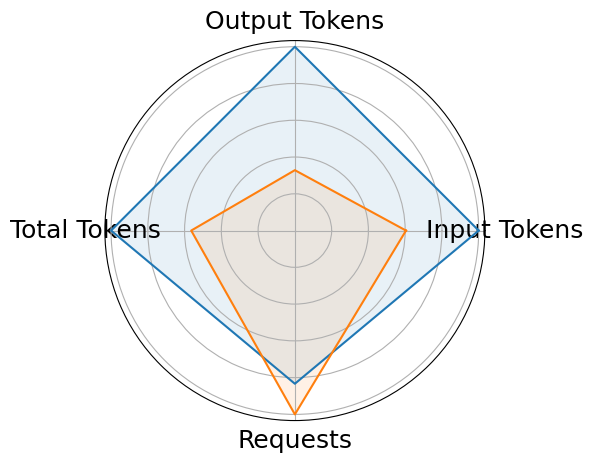

In [100]:
model_labels = plot_radar_for_tool(df_model_usage_10, 'semantic_kernel')

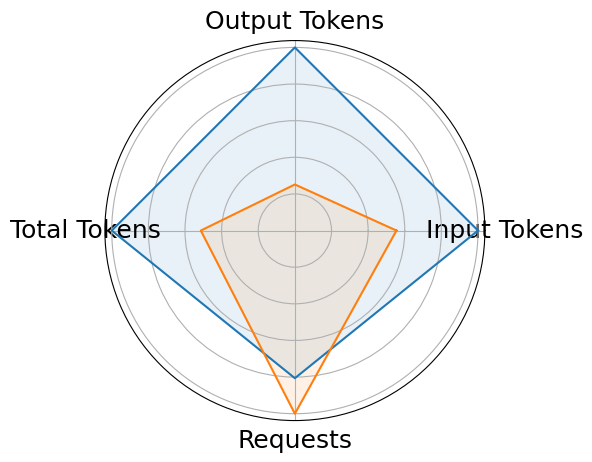

['gpt-4o-2024-08-06', 'gpt-4o-mini-2024-07-18']

In [101]:
plot_radar_for_tool(df_model_usage_10, 'dify')

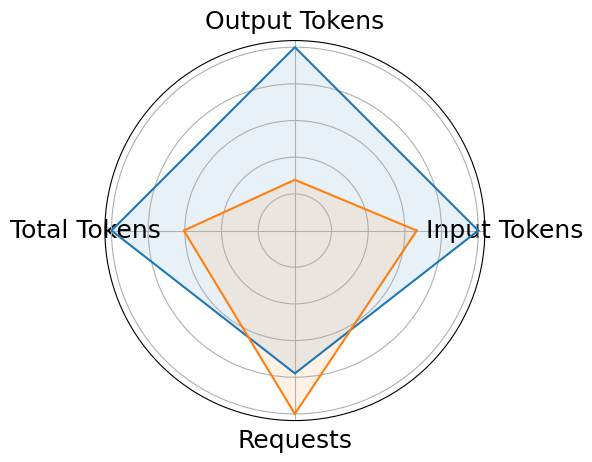

['gpt-4o-2024-08-06', 'gpt-4o-mini-2024-07-18']

In [102]:
plot_radar_for_tool(df_model_usage_10, 'autogen')

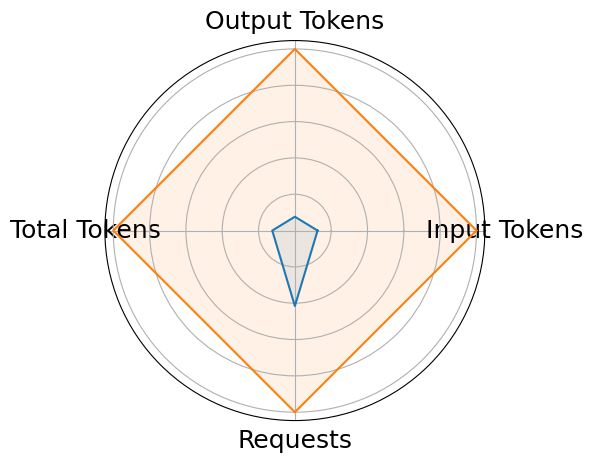

['gpt-4o-2024-08-06', 'gpt-4o-mini-2024-07-18']

In [103]:
plot_radar_for_tool(df_model_usage_10, 'semantic_kernel_chat')

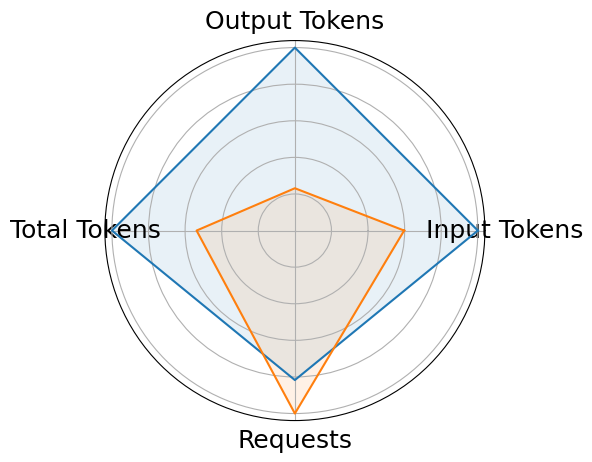

['gpt-4o-2024-08-06', 'gpt-4o-mini-2024-07-18']

In [104]:
plot_radar_for_tool(df_model_usage_10, 'autogpt')

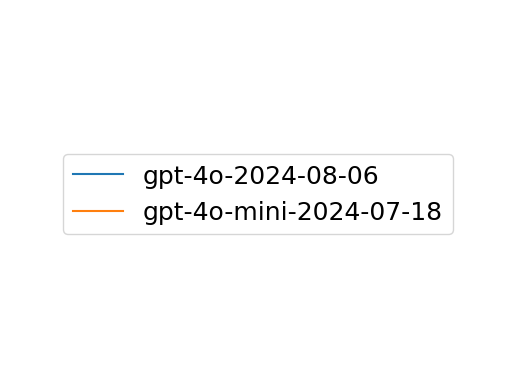

In [108]:
def plot_legend(model_labels):
    fig, ax = plt.subplots()
    for label in model_labels:
        ax.plot([], [], label=label)  # dummy handles
    ax.axis('off')
    ax.legend(loc='center', fontsize=18)
    plt.show()
plot_legend(model_labels)

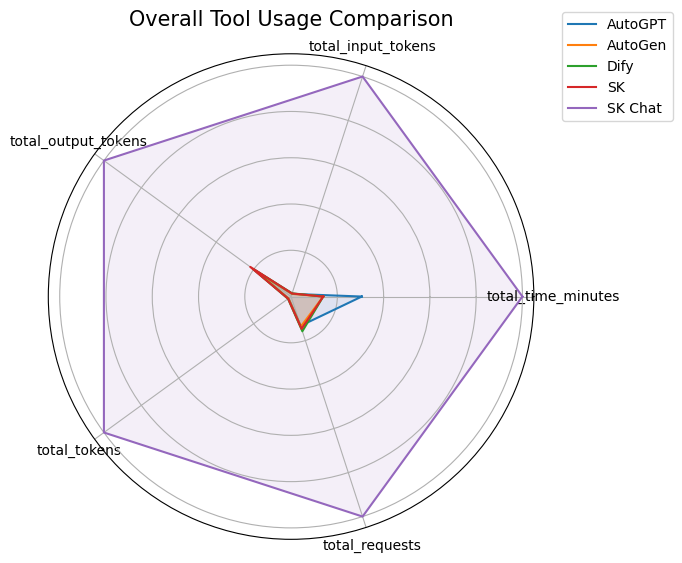

In [106]:

def plot_radar_tool_usage(df):


    df = df.copy()
    df['tool'] = df['tool'].map(tool_name_map).fillna(df['tool'])

    # Metrics to include
    metrics = ['total_time_minutes', 'total_input_tokens', 'total_output_tokens', 'total_tokens','total_requests']
    labels = ['total_time_minutes', 'total_input_tokens', 'total_output_tokens', 'total_tokens','total_requests']


    # Aggregate by tool
    grouped = df.groupby('tool')[metrics].sum()

    # Normalize each metric column
    grouped_norm = grouped / grouped.max()

    # Radar chart setup
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # complete the loop

    plt.figure(figsize=(7, 7))
    ax = plt.subplot(111, polar=True)

    for tool in grouped_norm.index:
        values = grouped_norm.loc[tool].tolist()
        values += values[:1]
        ax.plot(angles, values, label=tool)
        ax.fill(angles, values, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_yticklabels([])
    ax.set_title('Overall Tool Usage Comparison', size=15, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

plot_radar_tool_usage(df_usage_train_10)

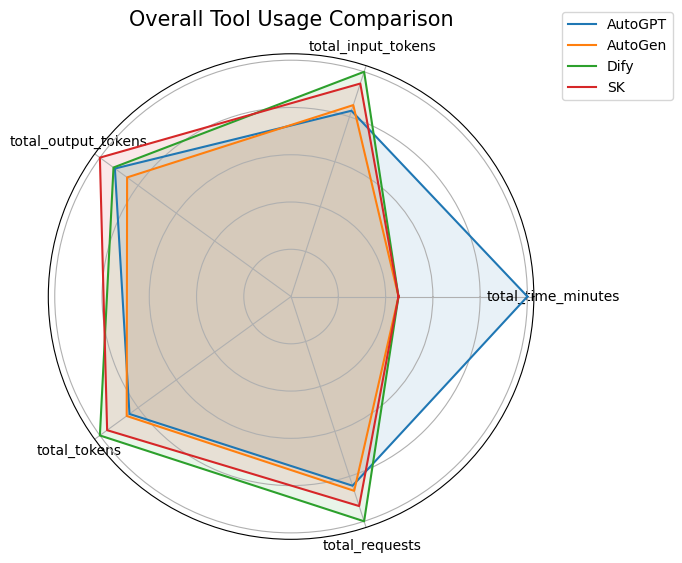

In [107]:
plot_radar_tool_usage(df_usage_train_10[df_usage_train_10["tool"]!= "semantic_kernel_chat"])